In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics as stat

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,mean_squared_log_error
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LassoLars, SGDRegressor, Ridge, LogisticRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
import xgboost as xgb



set_config(display='diagram') 

In [242]:
#Read train data
train = pd.read_csv("train.csv").drop(columns = 'Id')
submission = pd.read_csv("sample_submission.csv")

In [243]:
#Split into X and Y
train_X = train.loc[:, train.columns != 'SalePrice']
train_Y = train.loc[:, 'SalePrice']

In [244]:
#Transform into log prices for better target variable
train_Y = np.log(train_Y)

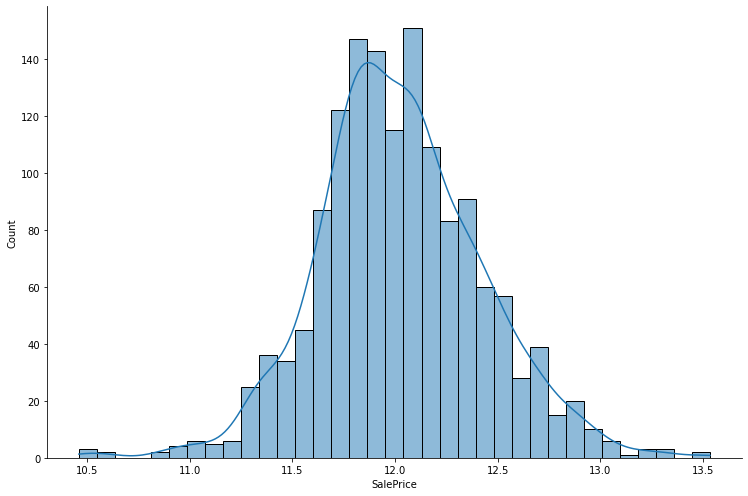

In [215]:
#Barchart for target variable
sns.displot(x=train_Y,kde=True,height=7,aspect=1.5);

The log-transformed target variable seems to be following a normal distribution

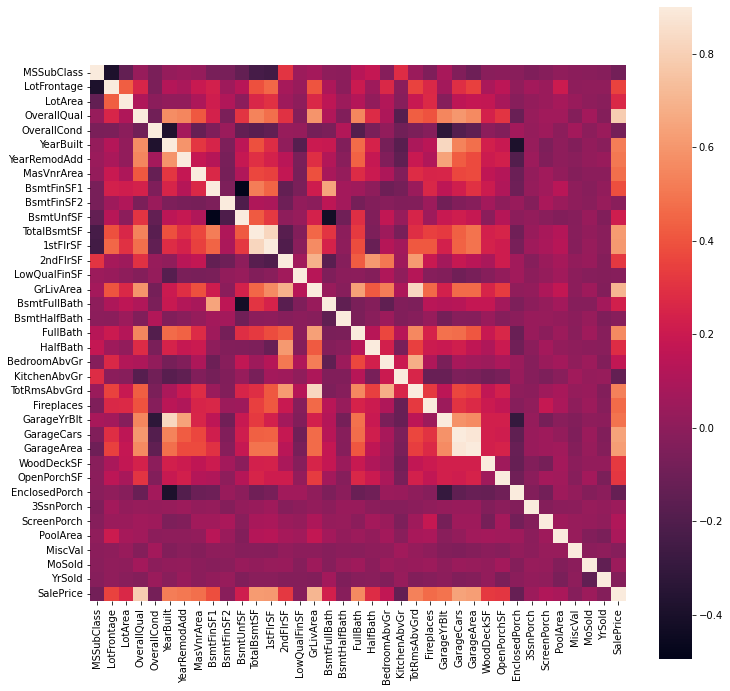

In [216]:
#Correlation matrix for numerical data
corrmat = train.corr()
plt.subplots(figsize=(12,12))
sns.heatmap(corrmat, vmax=0.9, square=True);

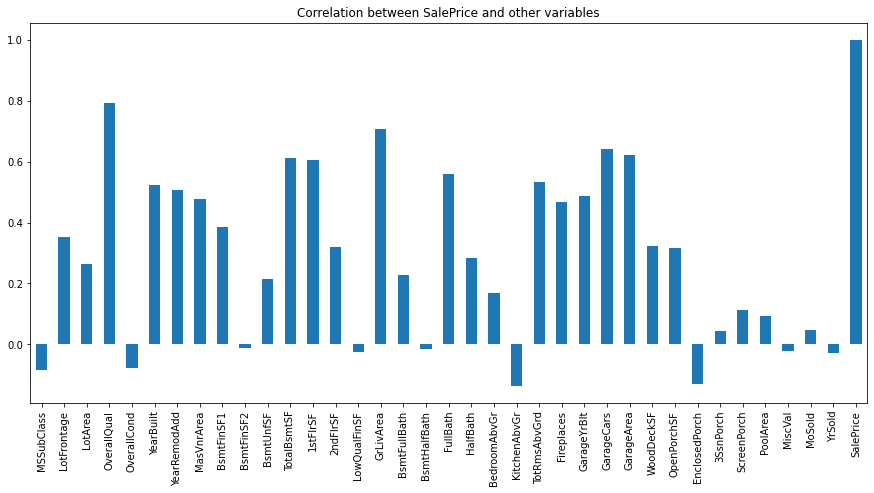

In [217]:
corrmat['SalePrice'].plot(kind='bar',figsize=(15,7),title='Correlation between SalePrice and other variables');

# Handling Missing Values 

In [245]:
def isnull_count(data):
    list_null = {}
    for col in data.columns:
        a = data[col].isnull().sum()
        list_null[col] = a
    return list_null

In [246]:
null_cols = isnull_count(train_X)

#These are the columns with NULL values
for i in range(len(null_cols)):
    if list(null_cols.values())[i]!= 0:
        print(list(null_cols.keys())[i])

LotFrontage
Alley
MasVnrType
MasVnrArea
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Electrical
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageQual
GarageCond
PoolQC
Fence
MiscFeature


In [247]:
null_cols_list = ['LotFrontage',
'Alley',
'MasVnrType',
'MasVnrArea',
'BsmtQual',
'BsmtCond',
'BsmtExposure',
'BsmtFinType1',
'BsmtFinType2',
'Electrical',
'FireplaceQu',
'GarageType',
'GarageYrBlt',
'GarageFinish',
'GarageQual',
'GarageCond',
'PoolQC',
'Fence',
'MiscFeature']

#Replace NaN's in categorical variables with None and numerical variables with 0.
for col in null_cols_list:
    if train_X[col].dtype == 'object':
        train_X[col] = train_X[col].replace({np.nan : None})
    if train_X[col].dtype == 'float64':
        train_X[col] = train_X[col].fillna(0)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22448\2477130717.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X[col] = train_X[col].fillna(0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22448\2477130717.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X[col] = train_X[col].replace({np.nan : None})


# Handling Categorical Variables

In [249]:
#Get categorical variables into a list
cat_cols = []
for col in train_X.columns:
    if train_X[col].dtype == 'O':
        cat_cols.append(col)

#Function for value_counts
def count_values(data):
    count_dict = {}
    for col in data.columns:
        a = data[col].value_counts()
        count_dict[col] = a
    return count_dict



# Prepare Dummies for Categorical data

In [252]:
#Convert categorical data into dummy variables
cat_cols_dummies = pd.get_dummies(train_X[cat_cols]) 

train_final = pd.concat([train_X[train_X.columns.difference(cat_cols)], cat_cols_dummies], axis = 1)


RandomForestRegressor(oob_score=True)

# Prepare Test Data

In [256]:
test = pd.read_csv("test.csv").drop(columns = 'Id')

In [258]:
#Missing values
null_cols = isnull_count(test)

In [259]:
null_cols_list = ['MSZoning',
'LotFrontage',
'Alley',
'Utilities',
'Exterior1st',
'Exterior2nd',
'MasVnrType',
'MasVnrArea',
'BsmtQual',
'BsmtCond',
'BsmtExposure',
'BsmtFinType1',
'BsmtFinSF1',
'BsmtFinType2',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
'BsmtFullBath',
'BsmtHalfBath',
'KitchenQual',
'Functional',
'FireplaceQu',
'GarageType',
'GarageYrBlt',
'GarageFinish',
'GarageCars',
'GarageArea',
'GarageQual',
'GarageCond',
'PoolQC',
'Fence',
'MiscFeature',
'SaleType']

#Replace NaN's in categorical variables with None and numerical variables with 0.
for col in null_cols_list:
    if test[col].dtype == 'object':
        test[col] = test[col].replace({np.nan : None})
    if test[col].dtype == 'float64':
        test[col] = test[col].fillna(0)

In [261]:
#Get categorical variables into a list
cat_cols = []
for col in test.columns:
    if test[col].dtype == 'O':
        cat_cols.append(col)

In [262]:
#Convert categorical data into dummy variables
cat_cols_dummies = pd.get_dummies(test[cat_cols]) 

test_final = pd.concat([test[test.columns.difference(cat_cols)], cat_cols_dummies], axis = 1)

Excluded some columns because they are not included in the test set. This may be caused by the difference between levels of some categorical data. 

In [272]:
non_test_cols = train_final[train_final.columns.difference(test_final.columns)].columns

In [274]:
train_final = train_final[train_final.columns.difference(non_test_cols)]

# Model Fit

In [292]:
model = xgb.XGBRegressor()
model.fit(train_final, train_Y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [294]:
cols_when_model_builds = model.get_booster().feature_names

In [295]:
test_pred = model.predict(test_final[cols_when_model_builds])

In [296]:
submission['SalePrice'] = np.exp(test_pred) # We converted it to log early on.
submission.to_csv('submission.csv', index=False)